In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-default-prediction/Default_Fin.csv


In [2]:
data = pd.read_csv('/kaggle/input/loan-default-prediction/Default_Fin.csv')
data.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


## Understanding Data Distribution

In [3]:
print(data.groupby(['Defaulted?', 'Employed'])[['Bank Balance', 'Annual Salary']].describe())
pd.crosstab(data['Employed'], data['Defaulted?'], normalize = 'index').round(2)

                    Bank Balance                                       \
                           count          mean          std       min   
Defaulted? Employed                                                     
0          0              2817.0  11381.762386  5406.643098      0.00   
           1              6850.0   8934.053396  5346.181753      0.00   
1          0               127.0  22324.546772  3944.821339  12158.64   
           1               206.0  20141.152427  3970.966677   7828.80   

                                                            Annual Salary  \
                          25%       50%       75%       max         count   
Defaulted? Employed                                                         
0          0          7684.32  11437.56  15125.88  28658.04        2817.0   
           1          4893.51   8904.78  12734.43  28692.12        6850.0   
1          0         19651.08  22671.96  25323.36  31851.84         127.0   
           1         17768

Defaulted?,0,1
Employed,,
0,0.96,0.04
1,0.97,0.03


3% are defaulters in Employed<br>
4.5% are defaulters in Unemployed

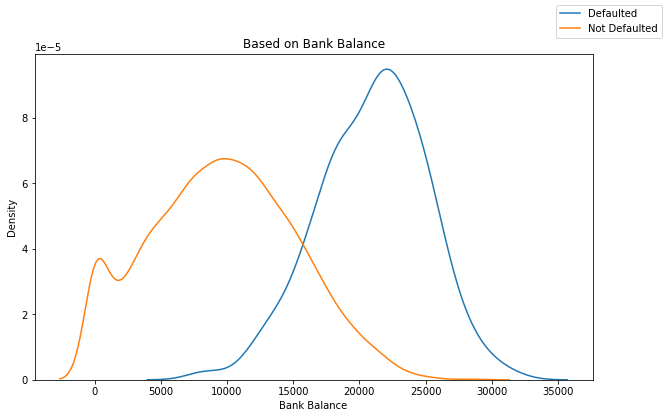

In [4]:
# defaulters vs bank balance distributions
fig = plt.figure(figsize=(10,6))

sns.kdeplot(data[data['Defaulted?']==1]['Bank Balance'])
sns.kdeplot(data[data['Defaulted?']==0]['Bank Balance'])

fig.legend(labels=['Defaulted', 'Not Defaulted'])
plt.title('Based on Bank Balance')
plt.show()

On average, defaulters have higher bank balance than non-defaulters.

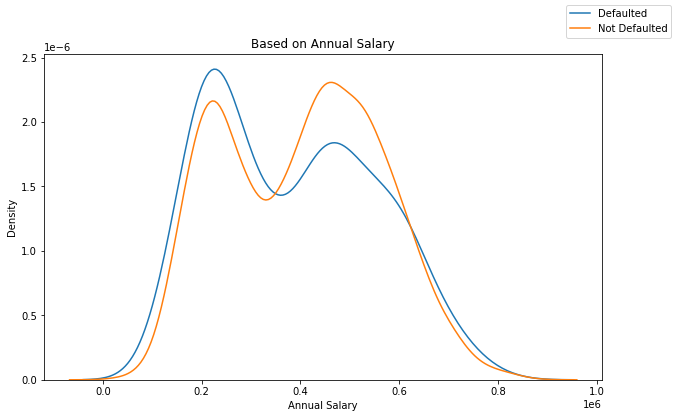

In [5]:
# defaulters vs bank balance distributions
fig = plt.figure(figsize=(10,6))

sns.kdeplot(data[data['Defaulted?']==1]['Annual Salary'])
sns.kdeplot(data[data['Defaulted?']==0]['Annual Salary'])

fig.legend(labels=['Defaulted', 'Not Defaulted'])
plt.title('Based on Annual Salary')
plt.show()

On average, number of defaulters with higher salary are lesser than lower annual salary

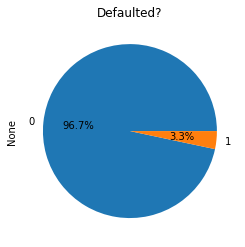

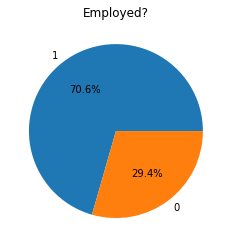

In [6]:
data.groupby('Defaulted?').size().plot.pie(autopct='%1.1f%%', title='Defaulted?');
plt.show()
label=[1,0]
plt.pie(data['Employed'].value_counts(), autopct='%1.1f%%',labels=label);
plt.title('Employed?');

# correlation between features or with target

In [7]:
import scipy.stats as st
print(st.ks_2samp(data['Annual Salary'], data['Bank Balance']))
# based on the pvalue we may say that these two features are highly correlated
# as the number of features are already small we are ignoring it

KstestResult(statistic=0.9997, pvalue=0.0)


# Training Model

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

In [9]:
feature_cols = ['Employed', 'Bank Balance', 'Annual Salary']

''' Rescaling to [0,1] '''
scaler = MinMaxScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

In [10]:
X = data[feature_cols]
y = data['Defaulted?']

validation_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, 
                                                    random_state=4, stratify=y)

# Model 1: Logistic Regression

In [11]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
print(model.coef_)

[[ 0.37752533 13.74108117  0.39631967]]


In [12]:
y_pred = model.predict(X_train)

print('Train metrics...')
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_pred = model.predict(X_test)

print('Test metrics...')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train metrics...
[[6651 1083]
 [  26  240]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      7734
           1       0.18      0.90      0.30       266

    accuracy                           0.86      8000
   macro avg       0.59      0.88      0.61      8000
weighted avg       0.97      0.86      0.90      8000

Test metrics...
[[1684  249]
 [   7   60]]
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1933
           1       0.19      0.90      0.32        67

    accuracy                           0.87      2000
   macro avg       0.60      0.88      0.62      2000
weighted avg       0.97      0.87      0.91      2000



In [13]:
''' metrics on original data '''
y_pred = model.predict(data[feature_cols])

def make_cm(matrix, columns):
    n = len(columns)
    act = ['actual defaulted?'] * n
    pred = ['prediction defaulted ?'] * n

    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

df_matrix=make_cm(
    confusion_matrix(data['Defaulted?'], y_pred),['No','Yes'])

display(df_matrix)
print(classification_report(data['Defaulted?'], y_pred))

prediction defaulted ?      
                                          No   Yes
actual defaulted? No                    8335  1332
                  Yes                     33   300

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      9667
           1       0.18      0.90      0.31       333

    accuracy                           0.86     10000
   macro avg       0.59      0.88      0.61     10000
weighted avg       0.97      0.86      0.90     10000



# Model 2: SVM

In [14]:
model = SVC(class_weight={0: 1, 1: 100})
model.fit(X_train, y_train)

SVC(class_weight={0: 1, 1: 100})

In [15]:
y_pred = model.predict(X_train)

print('Train metrics...')
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_pred = model.predict(X_test)

print('Test metrics...')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train metrics...
[[5378 2356]
 [   6  260]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      7734
           1       0.10      0.98      0.18       266

    accuracy                           0.70      8000
   macro avg       0.55      0.84      0.50      8000
weighted avg       0.97      0.70      0.80      8000

Test metrics...
[[1358  575]
 [   1   66]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.83      1933
           1       0.10      0.99      0.19        67

    accuracy                           0.71      2000
   macro avg       0.55      0.84      0.51      2000
weighted avg       0.97      0.71      0.80      2000



In [16]:
''' metrics on original data '''
y_pred = model.predict(data[feature_cols])

def make_cm(matrix, columns):
    n = len(columns)
    act = ['actual defaulted?'] * n
    pred = ['prediction defaulted ?'] * n

    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

df_matrix=make_cm(
    confusion_matrix(data['Defaulted?'], y_pred),['No','Yes'])

display(df_matrix)
print(classification_report(data['Defaulted?'], y_pred))

prediction defaulted ?      
                                          No   Yes
actual defaulted? No                    6736  2931
                  Yes                      7   326

              precision    recall  f1-score   support

           0       1.00      0.70      0.82      9667
           1       0.10      0.98      0.18       333

    accuracy                           0.71     10000
   macro avg       0.55      0.84      0.50     10000
weighted avg       0.97      0.71      0.80     10000

